# TODO / Commentaire
 - Est ce qu'on met en log les births ?
 - 
 
 use of contraceptive method
 abortion
 impact of emmigration
 children as workpower

# Wesh les reufs bien ou quoi

Importing data:
 - `valeurs_mensuelles.csv`: containing the number of birth in France for each month from 01-01-2004 to 01-10-2020.<br>
 Columns:
     - Période: month
     - Démographie - Nombre de naissances vivantes - France métropolitaine: number of birth for the corresponding month
     - Codes: Codes for explaining what type of value we have in our case we have "P" for 2020 data standing for "provisional" and "A" everywhere else standing for normale value. (see `caract.csv` for further details)
 - `GTD.csv`: containing the query number of google trend data for different categories.<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`.<br>
 Columns:
     - date: date of the query number
     - category id : columns containing all the query number in France for this category.
     
 - `categories.csv`: containing all the ids and names of the google trend categories<br>
   This dataframe is created in the notebook `GTD_preprocessing.ipynb`. The categories can be seen as a list with sub-categories here: https://github.com/pat310/google-trends-api/wiki/Google-Trends-Categories<br>
 Columns:
     - id: id of the diffrent category
     - name: Name of this category

In [1]:
#***Attention***  les donnees n'ont pas les memes tailles
#valeurs mensuelle = 202x1        01-01-2004  --> 01-10-2020 
#GTD               = 204×916      01-01-2004  --> 01-12-2020       916 categories       (donnée incomplete pour decembre)    (certaines categories ne donne pas de resultat exemple : category 42 "jazz" https://trends.google.com/trends/explore?cat=42&date=all&geo=FR )
# categories       = 1133x3                                       1133 categories       (il y a bien 1133 category differentes sur google trend mais dans GTD on a enlevé les category sans resultat  il en reste 916)

In [2]:
# Clear all variables
#%reset -f

# Importing librairies: numpy, matplotlib, pandas, statmodel
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.regression.rolling import RollingOLS

In [3]:
# Importing birth data with selecting correct columns and changing columns names
data_folder = './Data/'
birth_df = pd.read_csv(data_folder +'valeurs_mensuelles.csv', sep= ';', index_col= 0, skiprows=2, usecols=[0,1],header=0, names=['Période','births'])

# Changing indexes to panda date
birth_df.index = pd.to_datetime(birth_df.index)

# Putting sales data in log scale as we want
birth_df['births'] = birth_df['births'].apply(np.log)

# Getting an overview
birth_df = birth_df.sort_index()
birth_df

,births
Période,
2004-01-01,11.067248
2004-02-01,10.989048
2004-03-01,11.018383
2004-04-01,11.020529
2004-05-01,11.026028
...,...
2020-06-01,10.978490
2020-07-01,11.044521
2020-08-01,11.008744


In [4]:
# Importing google trend data
from numpy import linalg as LA
GTD_df = pd.read_csv(data_folder +'GTD.csv',index_col= 0)

# Getting an overview
GTD_df = GTD_df.loc['2004-01-01':'2020-10-01']
col = pd.to_numeric(GTD_df.columns)
GTD_df

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,100,53,89,54,46,50,74,60,78,43,...,4,67,41,19,29,30,58,84,73,31
2004-02-01,75,53,84,55,46,47,74,55,72,40,...,4,100,52,38,72,60,85,81,92,26
2004-03-01,68,55,85,62,45,50,77,59,77,45,...,2,51,51,21,66,37,39,82,71,26
2004-04-01,56,56,85,59,48,54,78,55,76,43,...,3,88,89,33,76,75,56,78,98,26
2004-05-01,75,56,86,50,47,54,75,59,76,45,...,3,14,51,23,45,59,100,70,78,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-01,56,33,21,67,24,94,63,29,60,62,...,34,14,21,15,31,32,76,46,13,11
2020-07-01,47,31,19,60,23,83,57,27,57,53,...,31,12,15,11,40,35,76,45,21,8
2020-08-01,44,33,18,53,24,81,54,25,55,58,...,31,9,12,9,23,34,79,50,20,9


In [5]:
# Importing google trend categories
categories_df = pd.read_csv(data_folder +'categories.csv',index_col= 0)

# Keeping only the elements of interest and getting an overview
categories_df = categories_df[categories_df['id'].isin(col)]
categories_df

,id,name
1426,0,Toutes catégories
240,3,Arts et divertissements
715,5,Informatique et électronique
396,7,Finance
785,8,Jeux
...,...,...
1415,1389,Agritourisme
1418,1390,Visites touristiques
1417,1391,Oenotourisme
1412,1392,Offices du tourisme et syndicats d'initiative


## Analyse des categories et selection

start_date, end_date: start and end date of the total period


normalisation_GTD = 
 - 0: no normlisation
 - 1: total
 - 2: par category
 
best_selection = 
 - 1: par correlation
 - 2: par improvement solo
 - 3: par improvement solo on the last months_shift months ex 12 shift by -12

 
Remove_seasonnality = 
 - 0: no
 - 1 : yes
 
nb_category_prediction: number of category used for prediction (1-20)

In [6]:
start_date = '2016-01-01' #'2015-01-01'   #'2004-01-01'
end_date = '2020-10-01'

normalisation_GTD = 1
 
best_selection = 3
months_shift = 12
 
Remove_seasonnality = 0
 
nb_category_prediction = 3

k = 12

### Selection dates

In [7]:
birth_df = birth_df.loc[start_date:end_date]
GTD_df = GTD_df.loc[start_date:end_date]

### Normalisation GTD

In [8]:
if normalisation_GTD == 1:
    mean_x = np.mean(GTD_df)
    std_x = np.std(GTD_df)
    x = GTD_df
    x = x - mean_x
    for i in range (len(std_x)):
        if std_x[i] == 0:
            std_x[i]=1
    x = x / std_x
    GTD_df = x
    
elif normalisation_GTD == 2:
    print("TODO")


GTD_df

,0,3,5,7,8,11,12,13,14,16,...,1381,1385,1386,1387,1388,1389,1390,1391,1392,1397
date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2.293215,2.833292,2.739373,1.227142,2.487108,-0.080381,0.931960,2.449701,2.094702,-1.008211,...,2.152518,1.103265,-0.007520,0.439209,0.576718,-0.654398,-0.809257,1.680285,0.289794,1.869595
2016-02-01,1.412378,2.318954,2.230130,0.769430,2.487108,-0.681940,1.210587,2.221639,1.521623,-1.184344,...,2.152518,2.702998,0.254169,0.732015,0.796782,-0.579536,-1.116034,0.108405,1.042392,2.360257
2016-03-01,0.531540,1.804616,1.720888,0.311718,1.550405,-0.531550,0.931960,2.221639,1.521623,-1.360477,...,2.152518,1.103265,0.166939,0.146403,1.016845,0.019361,-0.809257,0.894345,0.540660,1.378932
2016-04-01,0.311331,1.804616,1.211646,0.769430,1.082054,-0.531550,0.096078,1.537453,0.948544,-1.184344,...,2.152518,0.703331,0.079710,0.146403,-0.523599,0.767982,-1.116034,-0.284564,0.540660,1.378932
2016-05-01,0.751749,1.290279,0.702403,1.227142,1.082054,-0.681940,0.653333,1.081329,0.662005,-0.655944,...,1.749789,0.703331,-0.094749,0.146403,0.136591,0.543396,-0.400221,-0.284564,0.289794,1.378932
2016-06-01,-1.009926,1.290279,0.702403,0.769430,1.082054,-0.832330,0.096078,1.309391,1.808163,0.224722,...,1.951154,0.303398,-0.094749,-0.146403,-0.083472,0.618258,-0.093444,0.501375,0.540660,0.888269
2016-07-01,-1.009926,0.004434,-0.316081,-1.290275,1.550405,-1.283499,-2.132940,0.625205,-1.343771,-1.008211,...,1.145695,0.303398,-0.705356,-0.732015,-1.843981,0.917707,-0.502480,-1.463474,1.794990,-0.093057
2016-08-01,-0.569507,-0.252735,-0.825324,-1.747987,0.613702,-1.584279,-2.690194,0.169080,-1.916850,-1.536610,...,0.340237,-1.696269,-0.967044,-0.732015,-2.064044,0.693120,-1.320552,-1.070504,1.794990,-0.583720
2016-09-01,0.971959,0.261603,1.211646,-0.145994,0.145350,-0.982720,-0.182549,1.765515,0.088926,-1.184344,...,0.742966,1.103265,0.079710,-0.146403,1.016845,-0.055501,0.724629,0.108405,0.038927,-0.093057


### Saisonnalité

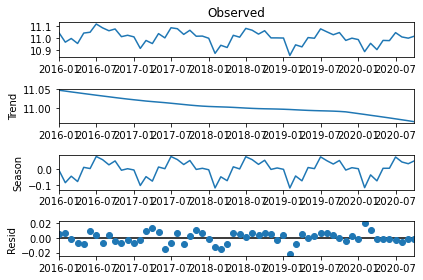

<AxesSubplot:xlabel='Période'>

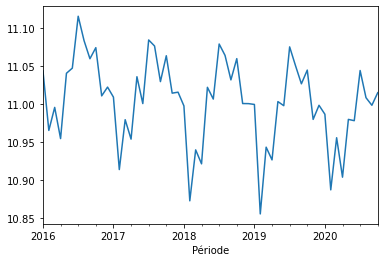

In [9]:
from statsmodels.tsa.seasonal import STL
#Checking seasonality
birth = STL(birth_df).fit()
birth.plot()
plt.show()

if Remove_seasonnality == 1:
    birth_df['births'] = birth_df['births'] - birth.seasonal

    
birth_df['births'].plot()

### Correlation

In [10]:
#Feature selection on the ENTIRE DATASET

if best_selection==1:
    
    # CORRELATION
    pearson = []
    kendall = []
    spearman = []
    temp_df=pd.DataFrame(GTD_df.loc['2004-01-01':'2020-10-01'], dtype='float') #Taking the time index that are also in the birth_df

    for i,j in enumerate(categories_df['id']):

        if str(j) in temp_df.columns:
            #Pearson correlation calculation
            pearsonTemp = np.abs(birth_df.iloc[:,0].corr(temp_df[str(j)],method='pearson'))
            pearson.append(pearsonTemp)
            #Kendall correlation calculation
            kendallTemp = np.abs(birth_df.iloc[:,0].corr(temp_df[str(j)],method='kendall'))       
            kendall.append(kendallTemp)
            #Spearman correlation calculation
            spearmanTemp = np.abs(birth_df.iloc[:,0].corr(temp_df[str(j)],method='spearman'))
            spearman.append(spearmanTemp)

        else:
            pearson.append(np.nan)
            kendall.append(np.nan)
            spearman.append(np.nan)

    #Normalizing our correlation indicators in order to combine them
    pearsonNorm = 100 / np.nanmax(pearson)
    categories_df['Pearson'] = np.multiply(pearsonNorm, pearson)
    kendallNorm = 100 / np.nanmax(kendall)    
    categories_df['Kendall'] = np.multiply(kendallNorm, kendall)
    spearmanNorm = 100 / np.nanmax(spearman)
    categories_df['Spearman'] = np.multiply(spearmanNorm, spearman)

    #Crossing between our correlations to see which feature is the best
    cal = pd.DataFrame([categories_df["Spearman"], categories_df["Pearson"], categories_df["Kendall"]]).transpose()
    cal = cal.mean(axis=1)
    categories_df['Mean'] = cal

    #Displaying the 10 best
    categories_best = categories_df.sort_values('Mean', ascending=False).iloc[0:20,:].reset_index(drop=True)
    
    # Create the dataframe with GTD
    predict_gtd = pd.DataFrame(index = birth_df.index, dtype='int')
    for i in range (nb_category_prediction):
        predict_gtd[str("id{}".format(categories_best.index[i]))] = np.ones((len(birth_df),1)) * categories_best.id[i]

## improvement function

In [11]:
#size of the rolling window = 17 = 4 mois ds le précédent paper, on prend 6 dans celui là comme en plus on a une saisonnalité de 6 mois
#https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5269518/
def best_feature_improvement(k,start = start_date, end = end_date):
    '''
    Input: 
        -start: start date in format '2004-01-01'
        -end: end date in format '2020-10-01'
        k: rolling windows size, recommended size : 6
    '''


    improvement = []

    #Checking for each feature
    for i in GTD_df.columns:

        #Setting the dfs
        df = pd.DataFrame()
        df['birth'] = birth_df.births
        nan = np.empty(6)
        nan[:] = 0
        df['birth_6'] =  [*nan , *birth_df.births[:-6].values] # Moving down 6 rows and putting 0 in the empty space
        nan = np.empty(12)
        nan[:] = 0
        df['birth_12'] =  [*nan , *birth_df.births[:-12].values] # Moving down 12 rows and putting 0 in the empty space    

        #Setting the feature of interest
        df[str("y0")] = GTD_df[str(i)]
        df = df.loc[start:end]
        df = df.reset_index(drop=True) #Resetting the index to [0-n] format

        #Basic reg
        res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
        params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

        #Trend reg with feature of interest
        res_trend = RollingOLS.from_formula('birth ~ birth_6 + birth_12 + y0', data=df, window=k).fit()#We use our rolling windows function
        params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
        params.columns = ['b0','b1','b2','b3']#Changing the parameters' columns names
        df = pd.concat([df, params], axis=1) #adding it to our dataframe
        df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 + df.b3 * df.y0   #predicting the values for the next month

        #Calculating MAE and Improvement
        mae_base = np.mean(abs(df.birth-df.predict_base))*100
        mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
        improvement_overall = (mae_base-mae_trends)*100 /mae_base
        improvement.append(improvement_overall)


    #Our df well ordered
    categories_best = categories_df.reset_index(drop=True)
    categories_best['Improvement'] = pd.DataFrame(improvement)
    categories_best = categories_best.sort_values('Improvement', ascending=False)
    categories_best = categories_best.reset_index(drop=True)
    
    return categories_best

### improvement solo 

In [12]:
if best_selection==2:
    # IMPROVEMENT
    categories_best = best_feature_improvement(k)
    
    # Create the dataframe with GTD
    predict_gtd = pd.DataFrame(index = birth_df.index)
    for i in range (nb_category_prediction):
        predict_gtd[str("id{}".format(categories_best.index[i]))] = np.ones((len(birth_df),1)) * categories_best.id[i]
    

### Improvement solo sur periode

In [ ]:
if best_selection==3:
    #create correct columns names
    columns_name = []
    for i in range (nb_category_prediction):
        columns_name.append(str("id{}".format(i)))
    
    #make shift
    Date_shifted = birth_df.index.shift(-months_shift, freq ='MS') 
    Date_shifted_1 = birth_df.index.shift(-1, freq ='MS') 
    
    predict_gtd = pd.DataFrame(dtype='float')
    #for each date
    for i in range(months_shift,len(birth_df)):
        #get correct time range
        start = Date_shifted[i]
        end = Date_shifted_1[i]
        #find best categories
        categories_best_temp = best_feature_improvement(k,start,end)
        #add it to df
        predict_gtd = predict_gtd.append(categories_best_temp.id[0:nb_category_prediction].transpose())
        print(birth_df.index[i])
        
    
    #create dataframe with correct indices and columns name
    predict_gtd.index = birth_df.index[months_shift:]
    predict_gtd.columns = columns_name

### best categories

In [ ]:
#categories_best.head(10)

In [17]:
predict_gtd = predict_gtd.astype(int) 
predict_gtd

,id0,id1,id2
Période,,,
2017-01-01,0,3,5
2017-02-01,0,3,5
2017-03-01,0,3,5
2017-04-01,0,3,5
2017-05-01,0,3,5
2017-06-01,0,3,5
2017-07-01,0,3,5
2017-08-01,0,3,5
2017-09-01,0,3,5


### Final prediction

In [24]:
def prediction(start,end,k,data,GTD,ids):
    df = data.copy()
    temp_GTD = GTD.copy()
    df = df.loc[start:end]
    temp_GTD = temp_GTD.loc[str(start-pd.DateOffset(months=1)):str(end)]
        
    #Features selection
    formula = str('birth ~ birth_6 + birth_12')
    columns_name = ['b0','b1','b2']
    for j,i in enumerate(ids):
        df["y%d"%j] = temp_GTD.loc[:,str(i)]
        formula = formula + ' + ' + str("y%d"%j)
        columns_name.append(str("b%d"%(j+ 3)))
        #GTD_df.loc[:,str(categories_best.id[i])]

    index_date = df.index #saving the index for later plotting
    df = df.reset_index(drop=True) #Resetting the index to [0-n] format


    res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
    params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

    res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
    params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
    params.columns = columns_name#Changing the parameters' columns names
    df = pd.concat([df, params], axis=1) #adding it to our dataframe
    df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
    for j,i in enumerate(ids):
        df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+j]*  df.iloc[:,3+j]  #predicting the values for the next month


    #add date index again
    df.index = index_date

    #MAE + Improvement overall calculation between the base fit and base+trend fit
    mae_base = np.mean(abs(df.birth-df.predict_base))*100
    mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
    improvement_overall = (mae_base-mae_trends)*100 /mae_base
    return df,improvement_overall

In [25]:
df = pd.DataFrame()
temp_df=pd.DataFrame(GTD_df, dtype='float')

#Birth_df Data
df['birth'] = birth_df.births
nan = np.empty(6)
nan[:] = 0
df['birth_6'] =  [*nan , *birth_df.births[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
df['birth_12'] =  [*nan , *birth_df.births[:-12].values] # Moving down 12 rows and putting 0 in the empty space


'''
ids=[]
for i in range (nb_category_prediction):
    ids.append(categories_best.id[i])
[df,improvement_overall] = prediction(start_date,end_date,k,df,temp_df,ids)
'''
predict_base=[np.nan]*(months_shift+1)
predict_trend=[np.nan]*(months_shift+1)
for i in range(months_shift+1,len(birth_df)):
    j=birth_df.index[i]
    ids = predict_gtd.loc[j,:]
    [pred,improvement_overall] = prediction(j -pd.DateOffset(months=months_shift),j,k,df,temp_df,ids)
    predict_base.append(pred['predict_base'][-1])
    predict_trend.append(pred['predict_trend'][-1])

df['predict_base'] = predict_base
df['predict_trend'] = predict_trend

In [26]:
df

,birth,birth_6,birth_12,predict_base,predict_trend
Période,,,,,
2016-01-01,11.044041,0.000000,0.000000,NaN,NaN
2016-02-01,10.965678,0.000000,0.000000,NaN,NaN
2016-03-01,10.995981,0.000000,0.000000,NaN,NaN
2016-04-01,10.954921,0.000000,0.000000,NaN,NaN
2016-05-01,11.040888,0.000000,0.000000,NaN,NaN
2016-06-01,11.047663,0.000000,0.000000,NaN,NaN
2016-07-01,11.115979,11.044041,0.000000,NaN,NaN
2016-08-01,11.083818,10.965678,0.000000,NaN,NaN
2016-09-01,11.060039,10.995981,0.000000,NaN,NaN


# Oldprediction
df = pd.DataFrame()
temp_df=pd.DataFrame(GTD_df, dtype='float')

#Birth_df Data
df['birth'] = birth_df.births
nan = np.empty(6)
nan[:] = 0
df['birth_6'] =  [*nan , *birth_df.births[:-6].values] # Moving down 6 rows and putting 0 in the empty space
nan = np.empty(12)
nan[:] = 0
df['birth_12'] =  [*nan , *birth_df.births[:-12].values] # Moving down 12 rows and putting 0 in the empty space

# Adding the google trend data
#df = pd.merge(df,predict_gtd,left_index = True, right_index = True)

#Features selection
formula = str('birth ~ birth_6 + birth_12')
columns_name = ['b0','b1','b2']
for i in range (nb_category_prediction):
    df[str("y{}".format(categories_best.index[i]))] = temp_df.loc[:,str(categories_best.id[i])]
    formula = formula + ' + ' + str("y{}".format(categories_best.index[i]))
    columns_name.append(str("b{}".format(categories_best.index[i] + 3)))
    #GTD_df.loc[:,str(categories_best.id[i])]
    
index_date = df.index #saving the index for later plotting
df = df.reset_index(drop=True) #Resetting the index to [0-n] format


res_base = RollingOLS.from_formula('birth ~ birth_6 + birth_12', data=df, window=k).fit() #We use our rolling windows function
params = pd.DataFrame(res_base.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
params.columns = ['a0','a1','a2'] #Changing the parameters' columns names
df = pd.concat([df, params], axis=1) #adding it to our dataframe
df['predict_base'] = df.a0 + df.a1*df.birth_6 + df.a2*df.birth_12 #predicting the values for the next month

res_trend = RollingOLS.from_formula(formula, data=df, window=k).fit()#We use our rolling windows function
params = pd.DataFrame(res_trend.params.shift(periods=1, axis=0)) #we shift the output parameters one row down in order to apply to the next mont (predict)
params.columns = columns_name#Changing the parameters' columns names
df = pd.concat([df, params], axis=1) #adding it to our dataframe
df['predict_trend'] = df.b0 + df.b1*df.birth_6 + df.b2*df.birth_12 
for i in range (nb_category_prediction):
    df['predict_trend'] = df['predict_trend'] + params.iloc[:,3+i]*  df.iloc[:,3+i]  #predicting the values for the next month

    
#add date index again
df.index = index_date

#MAE + Improvement overall calculation between the base fit and base+trend fit
mae_base = np.mean(abs(df.birth-df.predict_base))*100
mae_trends = np.mean(abs(df.birth-df.predict_trend))*100
improvement_overall = (mae_base-mae_trends)*100 /mae_base
improvement_overall

### Plotting

<function matplotlib.pyplot.show(close=None, block=None)>

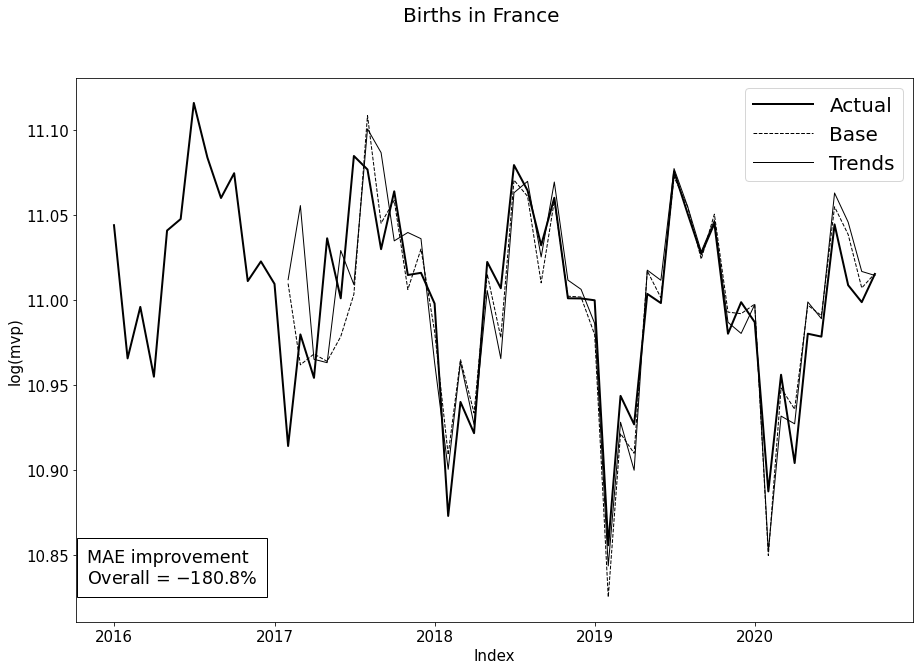

In [27]:
#Defining the overall parameters for the figure
params = {'legend.fontsize': 20,
          'legend.handlelength': 3,
          'figure.figsize': (15,10),
          'axes.labelsize' : 15,
          'xtick.labelsize' : 15,
          'ytick.labelsize' : 15}
plt.rcParams.update(params) #applying them

#plotting each curve with specific parameters
fig, ax = plt.subplots()
ax.plot(df.birth, 'k', linewidth=2, label='Actual') #Thicker line for the real data
ax.plot(df.predict_base, 'k--', linewidth=1,label='Base') #Doted line for the predicted curve with basic data
ax.plot(df.predict_trend, 'k', linewidth=1, label='Trends') #Classic line for the predicted curve with basic + trend data

#Defining figure title
plt.suptitle('Births in France', fontsize=20)

#Defining (x;y) labels
plt.xlabel('Index')
plt.ylabel('log(mvp)')

#Plotting the legend
plt.legend(loc="upper right")

#Creating the box with the MAE improvements
textstr = '\n'.join((
    r'MAE improvement',
    r'Overall = $%.1f$%%' % (improvement_overall, )))
ax.text(0.013, 0.135, textstr, transform=ax.transAxes, fontsize=17.5,
        verticalalignment='top', bbox=dict(facecolor='none', edgecolor='black', pad=10))

#Showing the plot
plt.show